In [0]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from functools import reduce

# The next two cells are used to read all the NHS data into a dictionary

In [0]:
# Run this ONLY IF YOU USE GOOGLE COLAB
google_drive_dir = 'ai_hack_2020'

try:
    from google.colab import drive
    drive.mount("/content/drive", force_remount=True)
    directory = "working_dir"
    if not os.path.exists(directory):
      os.symlink(os.path.join("drive", "My Drive", google_drive_dir), directory)
except ModuleNotFoundError as err:
    print("This only works on Google Colab. Skipping ...")

Mounted at /content/drive


In [0]:
# Load the data (will take a short while)
data = {}
for file in os.listdir("drive/My Drive/ai_hack_2020/nhs_data"):
    if file[-4:] != ".csv":
        continue
    if file in ["INDICATOR_MAPPINGS.csv", "CCG_EXCEPTIONS_EXCLUSIONS.csv"]:
        continue
    # print("Loading {} ...".format(file))
    data[file[:-4]] = pd.read_csv("drive/My Drive/ai_hack_2020/nhs_data/{}".format(file))
print("Done!")

Done!


# Begin the analysis

In [0]:
bnf = pd.read_csv('drive/My Drive/ai_hack_2020/nhs_data/bnf_sections.csv', sep=',')

In [0]:
# BNF codes (maximum 6 characters long)
# 2: Cardiovascular System
# 3: Respiratory System
# 4: Central Nervous System
# 5: Infections
# 6: Endocrine System

# Isolate disease areas of interest

prescriptions = {}

for k in data.keys():
  try:
    ki = int(k)
    for prefix in ('02', '03', '04', '05', '06'):
      if k.startswith(prefix): # and data[k].shape[0] > 50:
        dict_tmp = {'date' : data[k].iloc[:, 0], k : data[k].sum(axis=1)}
        prescriptions[k] = pd.DataFrame(dict_tmp, columns = ['date', k])
        # print(k, ':', prescriptions[k].shape)
  except ValueError:
    pass

del ki, dict_tmp

all_dfs = [prescriptions[df] for df in prescriptions.keys()]

# Merge all data frames

df_merged = reduce(lambda left, right: pd.merge(left, right, on='date', how='outer'), all_dfs).sort_values('date')

# Format df_merged

df_merged.set_index(df_merged['date'], inplace=True)
df_merged.drop('date', axis=1, inplace=True)
df_merged.drop(['02', '03', '04', '05', '06'], axis=1, inplace=True)
df_merged = df_merged[sorted([x for x in list(df_merged.columns)])]

In [0]:
bnf_sections = {}

for prefix in ('02', '03', '04', '05', '06'):
  df_tmp = df_merged.loc[:, df_merged.columns.str.startswith(prefix)].sum(axis=1)
  if all(df_tmp.iloc[:] != 0):
    df_tmp = df_tmp.to_frame()
    df_tmp.columns = [prefix]
    bnf_sections[prefix] = df_tmp
  else:
    pass

del df_tmp

all_bnfs = [bnf_sections[df] for df in bnf_sections.keys()]

bnf_merged = reduce(lambda left, right: pd.merge(left, right, on='date', how='outer'), all_bnfs)

bnf_merged.columns = list(bnf['code_name'][bnf['code_stem'].isin([int(x) for x in list(bnf_merged.columns)])])

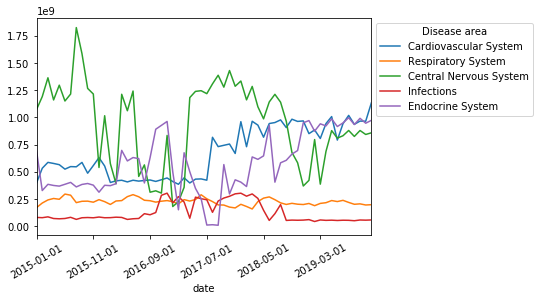

In [0]:
bnf_merged.plot(rot=30).legend(title='Disease area', bbox_to_anchor=(1, 1))

In [0]:
bnf_merged.head()

,Cardiovascular System,Respiratory System,Central Nervous System,Infections,Endocrine System
date,,,,,
2015-01-01,398394107.0,171222876.0,1.073753e+09,80780262.0,691031460.0
2015-02-01,532896603.0,213069511.0,1.191547e+09,78386109.0,327979138.0
2015-03-01,587059499.0,241564757.0,1.364961e+09,86063705.0,385317705.0
2015-04-01,577128574.0,255011068.0,1.161089e+09,70773330.0,374736748.0
2015-05-01,565800207.0,247697922.0,1.296993e+09,68110006.0,368701933.0


In [0]:
X_data = pd.read_csv('drive/My Drive/ai_hack_2020/nhs_data/X_data.csv', sep=',')

X_data.drop(['date', 'month_no'], axis=1).tail()

,tobacco,alcohol,nacrotics,health
2019-5-1,1468.666667,497.333333,209.0,2143.333333
2019-6-1,1468.666667,497.333333,209.0,2143.333333
2019-7-1,1469.000000,497.000000,209.0,2138.333333
2019-8-1,1469.000000,497.000000,209.0,2138.333333
2019-9-1,1469.000000,497.000000,209.0,2138.333333


In [0]:
np.load('drive/My Drive/ai_hack_2020/saved_arrays/code_chemical.npy')

array([[' (0101010C0)', ' (0101010E0)', ' (0101010F0)', ..., ' (2396)',
        ' (2398)', ' (2399)'],
       ['Aluminium Hydroxide', 'Hydrotalcite', 'Magnesium Carbonate',
        ..., 'Urostomy Bags', 'Urostomy Sets',
        'Ostomy Appliances R/Sub Allowed Pre 1985']], dtype='<U40')

# Cancer dataset

In [0]:
cancer_incidence = np.load('drive/My Drive/ai_hack_2020/saved_arrays/cancer_vals.npy')

# From 2001 to 2017

In [0]:
new_cancer = np.zeros((12*len(cancer_incidence[0])))
cancer_len = cancer_incidence.shape[1]
for i in range(0, cancer_len, 1):
  for j in range(12):
    new_cancer[i*12 + j] = cancer_incidence[1][i]/12

# Dementia dataset 1

In [0]:
dementia = np.load('drive/My Drive/ai_hack_2020/saved_arrays/dementia_drugs.npy')

# From January 2015 to December 2019

# Data manipulation continues in LSTM.ipynb

In [0]:
# treatments = [int(k) for k in list(prescriptions.keys()) if int(k) in list(bnf['code_stem'])]

# bnf[bnf['code_stem'].isin(treatments)]